# Árvores de decisão

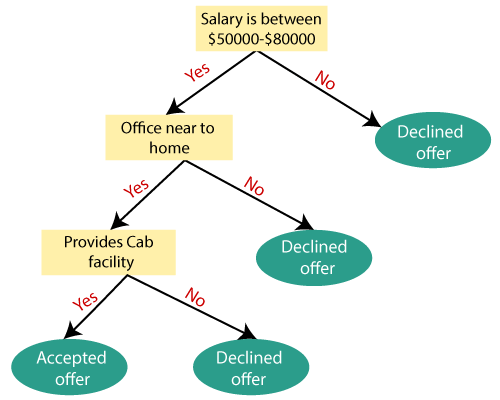


#### Algumas vantagens:

- Simples de entender e interpretar. É possível visualizar as árvores geradas como muita facilidade.
- Necessita de pouca preparação dos dados. Não tem necessidade de normalização dos dados, por exemplo.
- A implementação do scikit-learn não aceita valores ausentes.
- Consegue utilizar dados numéricos e categóricos.

#### Algumas desvantagens:

- Pode apresentar variância alta. Os modelos podem apresentar com frequência sobreajuste (overfitting) aos dados. Poda e ajuste dos hiperparâmetros são soluções para evitar este comportamento.
- O viés das árvores de decisão não as permite representar de maneira adequada tarefas como XOR e multiplexador.
- Árvores de decisão podem ser tendenciosas às classes majoritárias quando as classes estão desbalanceadas.

Gradient boosting machines (xgboost, lightgbm, catboost, ...)

## O que é uma árvore?

Árvore é um estrutura de dados muito utilizada na computação. Organizando os dados utilizando uma estrutura de árvore é possível realizar operações de inclusão, acesso e modificação com maior eficiencia. Uma árvore pode ser definida _recursivamente_ como uma coleção de nós a partir do nó raiz. Cada no guarda, no caso mais simples, um valor e uma lista de referencias para seus nós filhos.


<div>
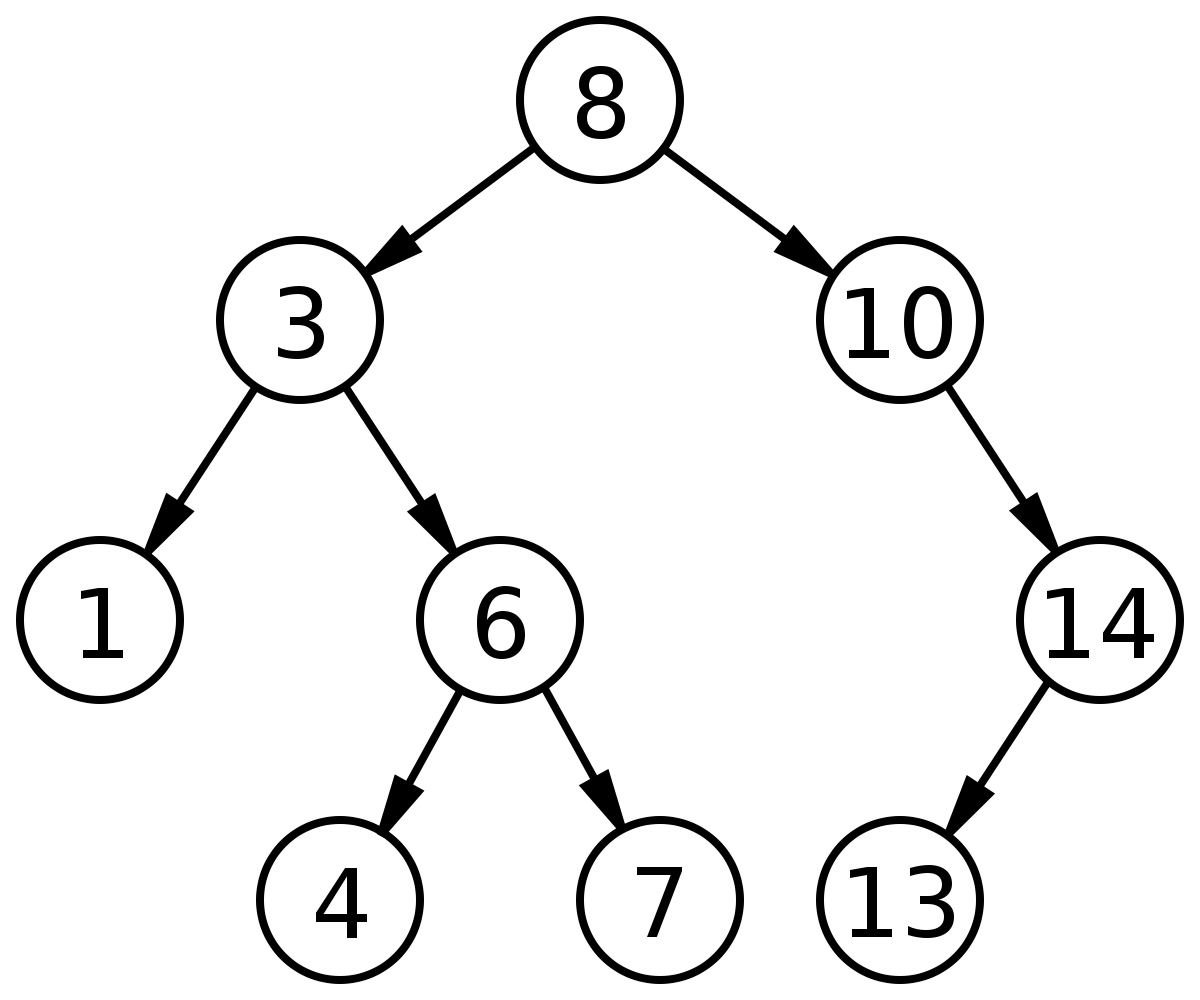
</div>

### Exemplo: árvore binária de busca

O exemplo mais comum de árvore que podemos ver é uma [árvore binária de busca](https://pt.wikipedia.org/wiki/%C3%81rvore_bin%C3%A1ria_de_busca). Através dessa estrutura podemos realizar busca em conjuntos de maneira **muito mais eficiente**. Cada nó da árvore tem apenas dois filhos, seguindo uma regra muito importante: todo nó na sub-árvore da esquerda possui valor menor que o seu próprio valor e todo nó na sub-árvore direita possui valor maior.

Vamos entender e implementar uma árvore binária de busca com operações de inserção e busca, vai ser bem util para entendermos a implementação da árvore de decisão.

In [1]:
class Node:
    def __init__(self, value):
        self.right = None
        self.left = None
        self.value = value
        
class Tree:
    def __init__(self):
        self.root = None

    def _add(self, node, value):
        if node == None:
            return Node(value)
        
        if value <= node.value:
            node.left = self._add(node.left, value)
        else:
            node.right = self._add(node.right, value)
        
        return node
                    
    def add(self, value):
        self.root = self._add(self.root, value)
    
    def _find(self, node, value):
        if node == None:
            return False
    
        if value < node.value:
            return self._find(node.left, value)
        elif value > node.value:
            return self._find(node.right, value)
        else: # Então é igual!
            return True
    
    def find(self, value):
        return self._find(self.root, value)

    def _in_order(self, node):
        if node == None:
            return
        self._in_order(node.left)
        print(node.value, end=' ')
        self._in_order(node.right)
            
    def print_tree(self):
        self._in_order(self.root)
        print()

Agora podemos popular a arvore e fazer algumas consultas

In [2]:
arvore = Tree()
for v in [5, 3, 1, 2, 9, 7, 18]:
    arvore.add(v)
    arvore.print_tree()

5 
3 5 
1 3 5 
1 2 3 5 
1 2 3 5 9 
1 2 3 5 7 9 
1 2 3 5 7 9 18 


In [3]:
print(arvore.find(5))
print(arvore.find(4))

True
False


## Voltando para árvores de decisão

O processo de construção de uma árvore de decisão é bem parecido com o que acabamos de ver. O principal elemento que estamos interessados é o descobrir qual é o melhor corte a ser feito nos dados. **Nosso objetivo é realizar o corte que resulte na menor impureza dos conjuntos gerados. Para medir essa impureza iremos testar cada corte possível em cada uma das features, calculando a entropia dos conjuntos gerados**.

Considerando que temos um conjunto $S$ dividido em nos conjuntos $S_1$ e $S_2$ temos que a impureza do corte é dada por

$$\text{Impureza} = \frac{|S_1|}{|S|}H(S_1) + \frac{|S_2|}{|S|}H(S_2)$$

Lembrando que $H(\cdot)$ é a entropia do conjunto calculada como

$$H(S) = - \sum_{c \in C} p(c) log_2 p(c)$$

onde $p(c)$ é a proporção dos elementos de $S$ que pertencem a classe $c$.

### Implementando uma árvore de decisão

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from scipy.stats import entropy
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split

In [5]:
class TreeNode:
    def __init__(self, feature, value):
        self.feature = feature
        self.value = value
        self.left = None
        self.right = None

class DecisionTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        
    def _calc_inpurity(self, data, target, col, val):
        # Separando quem cai de qual lado do corte
        target_less = target[data[col] <= val]
        target_greater = target[data[col] > val]

        # Calculando a proporção em cada lado do corte
        n_less = target_less.shape[0]/target.shape[0] 
        n_greater = target_greater.shape[0]/target.shape[0] 

        # Distribuição do target em cada grupo
        p_less = target_less.value_counts(normalize=True)
        p_greater = target_greater.value_counts(normalize=True)

        # Calculando a impureza
        inpurity = n_less * entropy(p_less) + n_greater * entropy(p_greater)

        return inpurity
    
    def _find_best_cut(self, data, target):
        best_cut = {
            'col': None,
            'val': None,
            'inpurity': 1e9 # inf
        }
        
        # Para cada feature dos dados
        for col in data.columns:
            sorted_col = data[col].unique()
            sorted_col.sort()
            # Para cada possível valor da feature
            for val in sorted_col:
                # Calculamos a impureza desse corte
                inpurity = self._calc_inpurity(data, target, col, val)
                # Se impureza for menor que antes esse é nosso novo melhor corte
                if inpurity < best_cut['inpurity']:
                    best_cut['col'] = col
                    best_cut['val'] = val
                    best_cut['inpurity'] = inpurity

        return best_cut['col'], best_cut['val']
    
    def _build_tree(self, data, target, depth, max_depth):
        # Se chegamos na profundidade máxima paramos
        if depth == max_depth:
            return target.mode()[0] # Classe é a mais frequente
        # Se nó é totalmente puro paramos
        if target.nunique() == 1:
            return target.iloc[0] # Classe é a única presente

            
        # Procura qual corte é melhor
        col, val = self._find_best_cut(data, target)

        # Cria o nó atual dizendo qual é o corte (feature e valor)
        node = TreeNode(col, val)
        
        # Particionando os dados da esquerda
        data_left = data[data[col] <= val]
        target_left = target[data[col] <= val]
        # E da direita
        data_right = data[data[col] > val]
        target_right = target[data[col] > val]
        
        # Chamamos a função recursivamente para os dois filhos
        node.left = self._build_tree(data_left, target_left, depth+1, max_depth)
        node.right = self._build_tree(data_right, target_right, depth+1, max_depth)
        
        # Quando os dois filhos tiverem prontos retornamos o nó
        return node
        
    def fit(self, X_train, y_train):
        # Treinar é montar a árvore
        self.root = self._build_tree(X_train, y_train, 1, self.max_depth)
    
    def _predict(self, node, query):
        # Se não for um nó é a classe em si, então retorna ela
        if not isinstance(node, TreeNode):
            return node
        
        # Se valor da for menor ou igual vai para o filho da esquerda
        if query[node.feature] <= node.value:
            return self._predict(node.left, query)
        
        # Se valor da for maior vai para o filho da esquerda
        else:
            return self._predict(node.right, query)
    
    def predict(self, X_test):
        # Lista para armazenar a previsão de cada exemplo
        y_pred = []
        
        # Prevendo a classe de cada exemplo
        for i in range(X_test.shape[0]):
            pred = self._predict(self.root, X_test.iloc[i])
            y_pred.append(pred)
        
        # Retornamos um np.array
        y_pred = np.array(y_pred)

        return y_pred

### Testando nossa implementação

In [6]:
data = load_iris()
df = pd.DataFrame(np.c_[data.data, data.target], columns=data.feature_names + ['target'])

X, y = df.iloc[:, :-1], df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(120, 4)
(30, 4)
(120,)
(30,)


In [7]:
clf = DecisionTree(max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

np.mean(y_pred == y_test)

0.9333333333333333

Podemos ver que o resultado ficou bem legal! Ainda tem muito o que pode ser melhorado em termos de eficiência, mas as ideias fundamentais estão todas nesse código.

---
<div>
<img src="groot.gif" width="800"/>
</div>